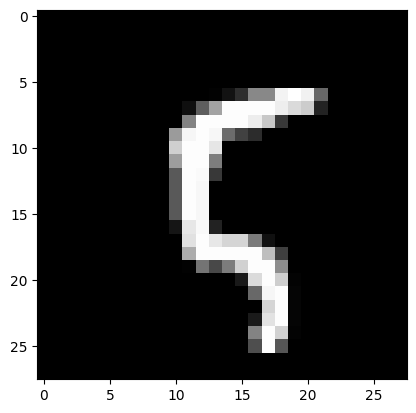

5


In [8]:
import numpy as np 
import mnist 
import matplotlib.pyplot as plt 
from pylab import cm
X = mnist.download_and_parse_mnist_file("/mnt/c/Users/Owner/Downloads/train-images-idx3-ubyte.gz") 
Y = mnist.download_and_parse_mnist_file("/mnt/c/Users/Owner/Downloads/train-labels-idx1-ubyte.gz")
idx = 100 
plt.imshow(X[idx], cmap=cm.gray) 
plt.show() 
print(Y[idx])